## Поключение библиотек и модулей

In [1]:
import numpy as np
import pandas as pd

import re
from time import time

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
import scipy.sparse as ss

import matplotlib.pyplot as plt
import seaborn as sns

from optimization import SGDClassifier, GDClassifier

## Экспериментальная часть:

### 1. Загрузка и предварительная обработка датасета

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test_labels = pd.read_csv('test_labels.csv')

In [5]:
y_train = df_train['toxic'].replace(0, -1)
y_test = df_test_labels['toxic'].replace(0, -1)

1) Приведение текста к нижнему регистру \
2) Замена символов, не являющихся буквами или цифрами, на пробелы

In [6]:
%%time
def standart(df):
    X = df['comment_text']
    X = X.replace('\n', ' ',regex=True)
    X = X.replace('[^0-9a-zA-Z]+', ' ',regex=True)
    X = X.replace('\s+', ' ',regex=True)
    X = X.str.lower().str.strip()
    return X

X_train = standart(df_train)
X_test = standart(df_test)

CPU times: user 9.19 s, sys: 88.5 ms, total: 9.28 s
Wall time: 9.28 s


Проверка результата

In [7]:
X_train

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really don t think you understand i came...
Name: comment_text, Length: 159571, dtype: object

Соотношение размеров тестовой и обучающей выборки, процент содержания токсичных комментариев в той и другой:

In [8]:
part = y_test.shape[0] / (y_test.shape[0] + y_train.shape[0])
print('Test:Train = {:.1f}% : {:.1f}%'.format(part * 100, (1 - part) * 100))

print('Train size: {} toxic: {:.1f}%'.format(
    y_train.shape[0], (y_train==1).mean() * 100))

print('Test size: {} toxic: {:.1f}%'.format(
    y_test.shape[0], (y_test==1).mean() * 100))

Test:Train = 49.0% : 51.0%
Train size: 159571 toxic: 9.6%
Test size: 153164 toxic: 4.0%


Видно, что классы несбалансированы.

### 2. Преобразование выборки в разреженную матрицу

In [9]:
def sparsizer(min_df, X_train, X_test, vectorizer):
    params = {'min_df': min_df}
    if vectorizer=='count':
        vec = CountVectorizer(**params)
    if vectorizer=='tfid':
        vec = TfidfVectorizer(**params)
    X_train = vec.fit_transform(X_train)
    X_test = vec.transform(X_test)
    vec_train = ss.csr_matrix(np.ones(X_train.shape[0])[:, np.newaxis])
    vec_test = ss.csr_matrix(np.ones(X_test.shape[0])[:, np.newaxis])

    X_train = ss.hstack((X_train, vec_train))
    X_test = ss.hstack((X_test, vec_test))
    return X_train, X_test

Min_df = 1.0 по умолчанию. Остаются все слова.

In [10]:
X_train = standart(df_train)
X_test = standart(df_test)
X_train, X_test = sparsizer(1, X_train, X_test, 'count')
X_train

<159571x182232 sparse matrix of type '<class 'numpy.float64'>'
	with 7111676 stored elements in COOrdinate format>

min_df = 0.0001

In [11]:
X_train = standart(df_train)
X_test = standart(df_test)
X_train, X_test = sparsizer(1, X_train, X_test, 'count')
X_train

<159571x182232 sparse matrix of type '<class 'numpy.float64'>'
	with 7111676 stored elements in COOrdinate format>

### 3. Исследование градиентного спуска для задачи логистической регрессии

**1) Зависимость от параметров шага**

Создадим датафрейм df_history с экспериментами: step_alpha перебирается от 0.1 до 5 с шагом 1, а step_beta от 0 до 2 с шагом в 0.5. Помимо перебираемых параметров в датафрейме присутствуют время выполнения, итоговая точность (accuracy), итоговое значение функции ошибки, а так же history для каждого спуска.

In [13]:
%%time

df_history = pd.DataFrame(columns=['step_alpha', 'step_beta', 'accuracy', 'time', 'history'])

for step_alpha in np.arange(0.1, 5.1, 0.5):
    for step_beta in np.arange(0.0, 2.5, 0.5):
        gdc = GDClassifier('binary_logistic', step_alpha=step_alpha, 
                           step_beta=step_beta, tolerance=1e-4, max_iter=500, l2_coef=0.0)
        start = time()
        history = gdc.fit(X_train, y_train, trace=True)
        y_pred = gdc.predict(X_test) 
        pred_proba = gdc.predict_proba(X_test)
        df_history = df_history.append({
            'step_alpha': round(step_alpha, 1),
            'step_beta': round(step_beta, 1),
            'accuracy': history['accuracy'][-1],            
            'time': time() - start,
            'history': history
        }, ignore_index=True) 

CPU times: user 1h 2min 9s, sys: 2h 26min 48s, total: 3h 28min 57s
Wall time: 20min 21s


Рассмотрим с помощью тепловой карты зависимость итоговой точности, ошибки и времени от параметров step_alpha и step_beta

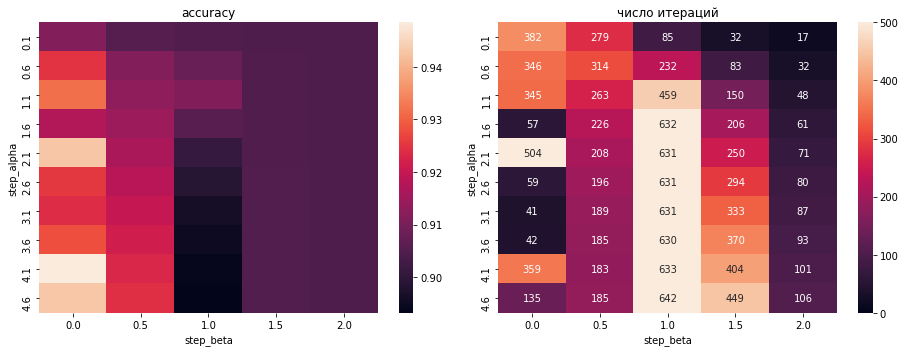

In [14]:
fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(121)
sns.heatmap(df_history.pivot('step_alpha', 'step_beta', 'accuracy'))
ax1.set(xlabel='step_beta', ylabel='step_alpha', title='accuracy')

ax2 = fig.add_subplot(122)

sns.heatmap((500/47 * df_history.pivot('step_alpha', 'step_beta', 'time')).astype(int), annot=True, fmt="d", vmin=0, vmax=500)
ax2.set(xlabel='step_beta', ylabel='step_alpha', title='число итераций')

plt.tight_layout()

Построим графики зависимости для некоторых спусков

In [15]:
def plots(history):

    fig = plt.figure(figsize = (20, 10))
    ax1 = fig.add_subplot(221)
    ax1.plot(np.array(history['time']).cumsum(), np.array(history['func']))
    title = 'Зависимости функции ошибки от реального времени работы и номера итерации'
    ax1.set(xlabel='Время работы s', ylabel='func', title=title)
    ax11 = ax1.twiny()
    ax11.set(xticks=np.arange(len(history['func']), step=50), xlabel='Номер итерации')

    ax2 = fig.add_subplot(222)
    ax2.plot(np.array(history['time']).cumsum(), np.array(history['accuracy']))
    title = 'Зависимости точности от реального времени работы и номера итерации'
    ax2.set(xlabel='Время работы s', ylabel='accuracy', title=title)
    ax22 = ax2.twiny()
    ax22.set(xticks=np.arange(len(history['accuracy']), step=50), xlabel='Номер итерации')

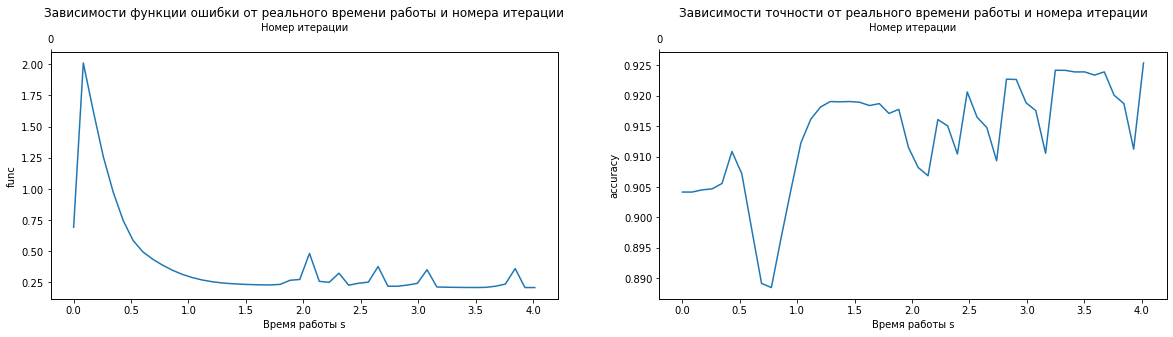

In [16]:
mask = (df_history['step_alpha'] == 2.6) & (df_history['step_beta'] == 0.0)
history = df_history[mask]['history'].values[0]
plots(history)

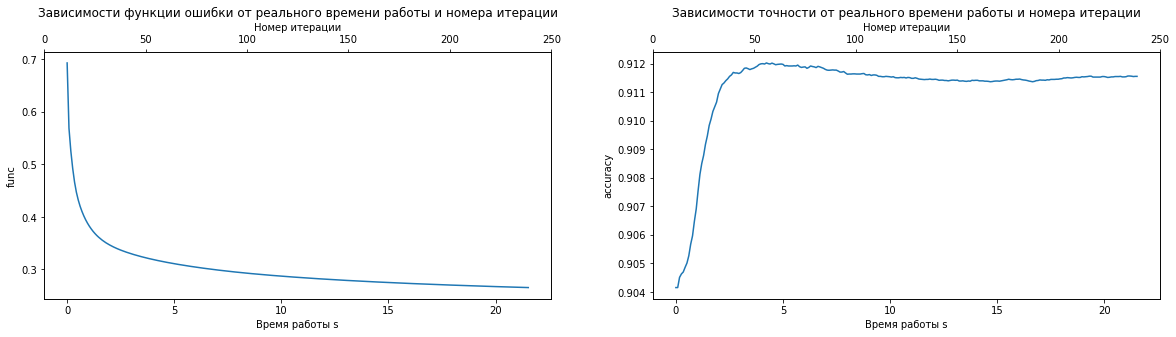

In [17]:
mask = (df_history['step_alpha'] == 0.6) & (df_history['step_beta'] == 0.5)
history = df_history[mask]['history'].values[0]
plots(history)

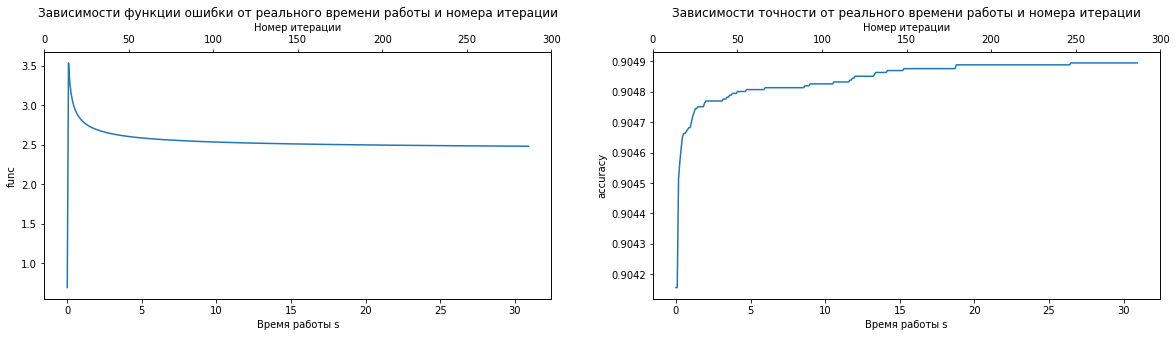

In [18]:
mask = (df_history['step_alpha'] == 4.6) & (df_history['step_beta'] == 1.5)
history = df_history[mask]['history'].values[0]
plots(history)

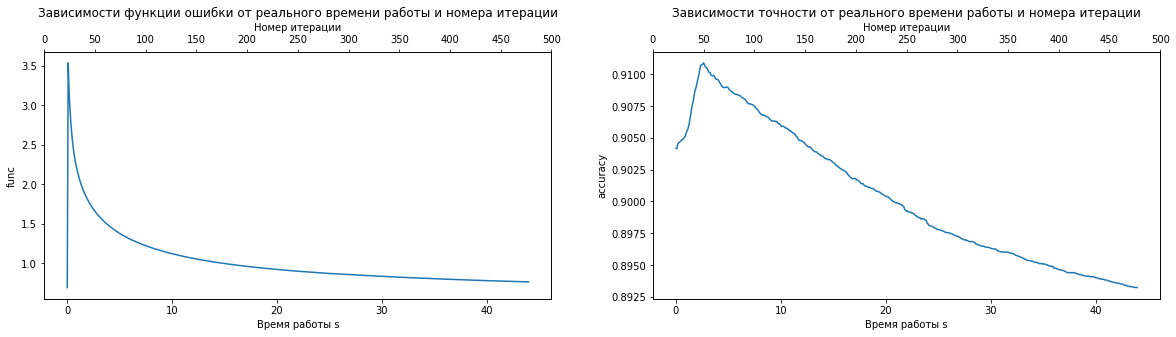

In [19]:
mask = (df_history['step_alpha'] == 4.6) & (df_history['step_beta'] == 1.0)
history = df_history[mask]['history'].values[0]
plots(history)

**2) Зависимость от начального приближения $w_0$**

Нулевое начальное приближение:

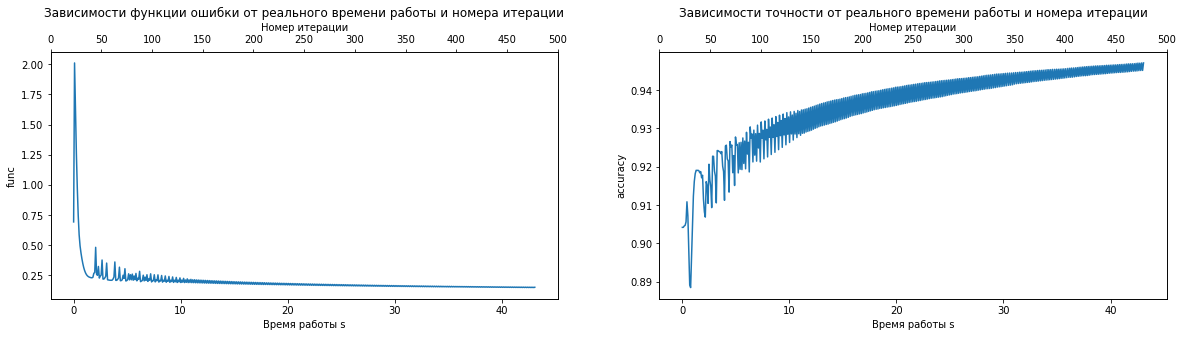

In [20]:
gdc = GDClassifier('binary_logistic', step_beta=0.0, step_alpha=2.6, 
                   tolerance=1e-5, max_iter=500, l2_coef=0.0)
history = gdc.fit(X_train, y_train, trace=True)
plots(history)

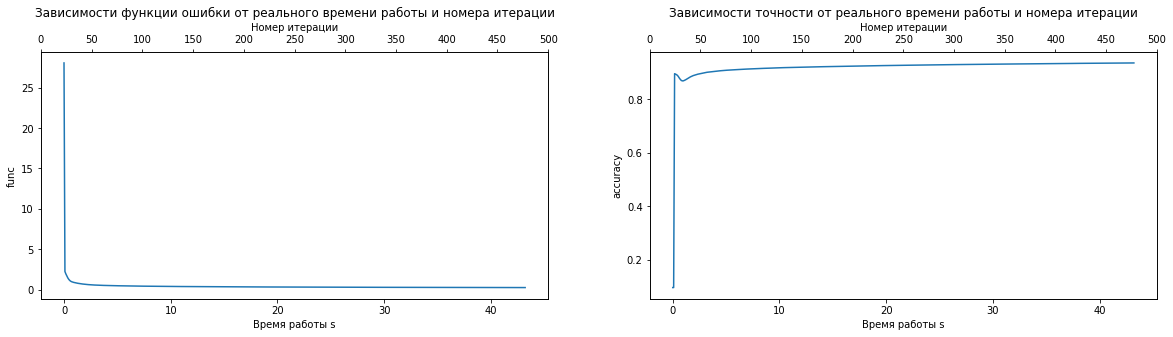

In [21]:
w_0 = (gdc.get_weights() + 1) / 2
history = gdc.fit(X_train, y_train, trace=True, w_0=w_0)
plots(history)

### 3. Исследование стохастического градиентного спуска для задачи логистической регрессии

#### 1) Зависимость от размера батча

CPU times: user 17.3 s, sys: 40.7 s, total: 58 s
Wall time: 5.69 s


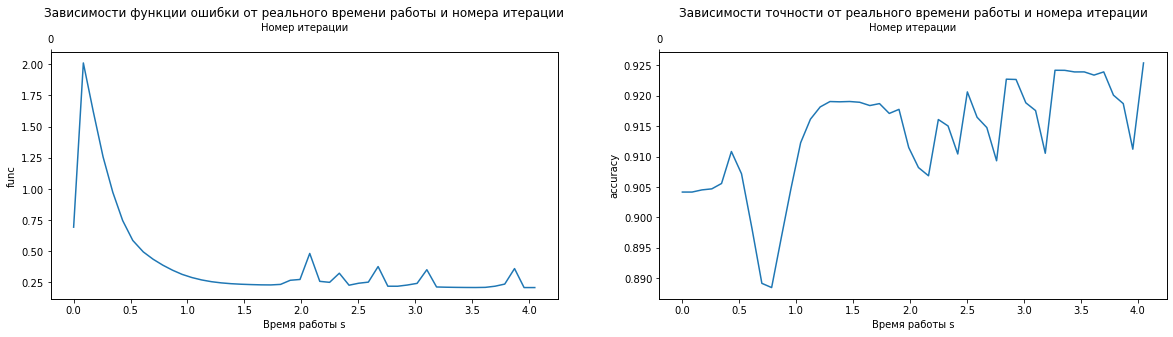

In [22]:
%%time
gdc = GDClassifier('binary_logistic', step_alpha=2.6, step_beta=0.0, tolerance=1e-4, max_iter=500, l2_coef=0.0)
history = gdc.fit(X_train, y_train, trace=True)
y_pred = gdc.predict(X_test)
pred_proba = gdc.predict_proba(X_test)
plots(history)

CPU times: user 38.9 s, sys: 1min 29s, total: 2min 8s
Wall time: 13.2 s


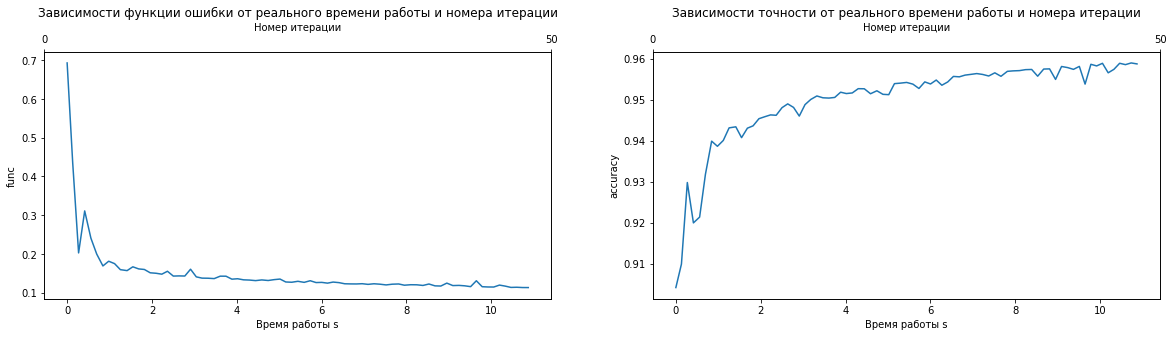

In [23]:
%%time
sgdc = SGDClassifier('binary_logistic', batch_size=5000, step_alpha=2.6, step_beta=0.0, 
                          tolerance=1e-4, max_iter=500, random_seed=153, l2_coef=0.0)
history = sgdc.fit(X_train, y_train, trace=True)
y_pred = sgdc.predict(X_test)
pred_proba = sgdc.predict_proba(X_test)
plots(history)

CPU times: user 31.6 s, sys: 1min 1s, total: 1min 32s
Wall time: 13.9 s


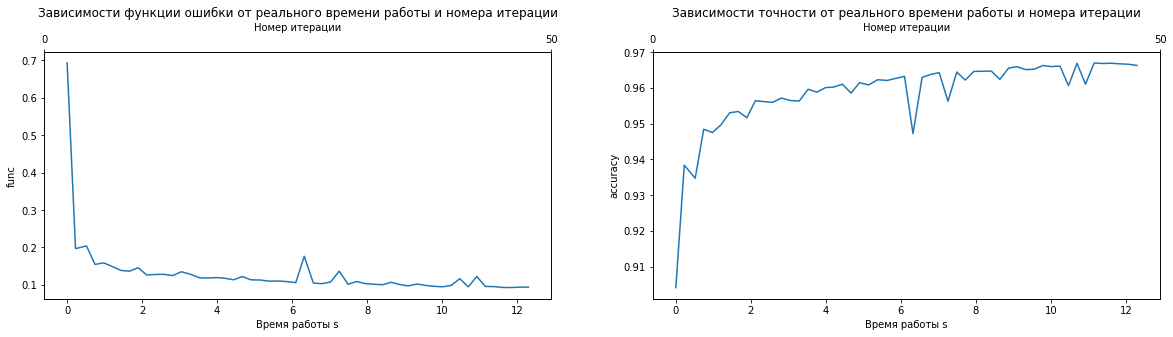

In [24]:
%%time
sgdc = SGDClassifier('binary_logistic', batch_size=1000, step_alpha=2.6, step_beta=0.0, 
                          tolerance=1e-4, max_iter=500, random_seed=153, l2_coef=0.0)
history = sgdc.fit(X_train, y_train, trace=True)
y_pred = sgdc.predict(X_test)
pred_proba = sgdc.predict_proba(X_test)
plots(history)

CPU times: user 7min 39s, sys: 5min 21s, total: 13min
Wall time: 6min 9s


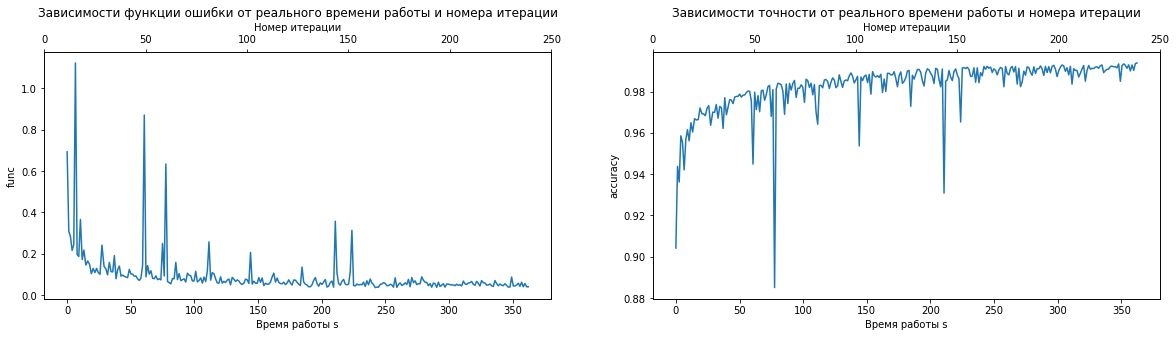

In [25]:
%%time
sgdc = SGDClassifier('binary_logistic', batch_size=100, step_alpha=2.6, step_beta=0.0, 
                          tolerance=1e-4, max_iter=500, random_seed=153, l2_coef=0.0)
history = sgdc.fit(X_train, y_train, trace=True)
y_pred = sgdc.predict(X_test)
pred_proba = sgdc.predict_proba(X_test)
plots(history)

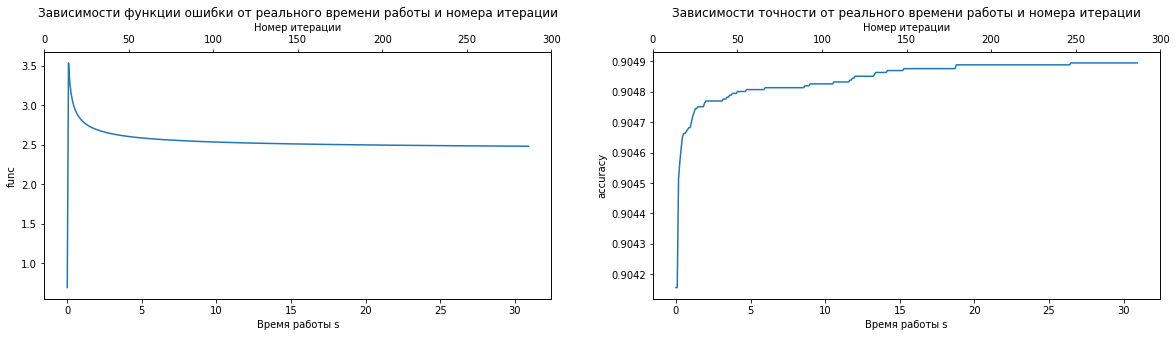

In [26]:
mask = (df_history['step_alpha'] == 4.6) & (df_history['step_beta'] == 1.5)
history = df_history[mask]['history'].values[0]
plots(history)

CPU times: user 52.1 s, sys: 1min 58s, total: 2min 50s
Wall time: 17.1 s


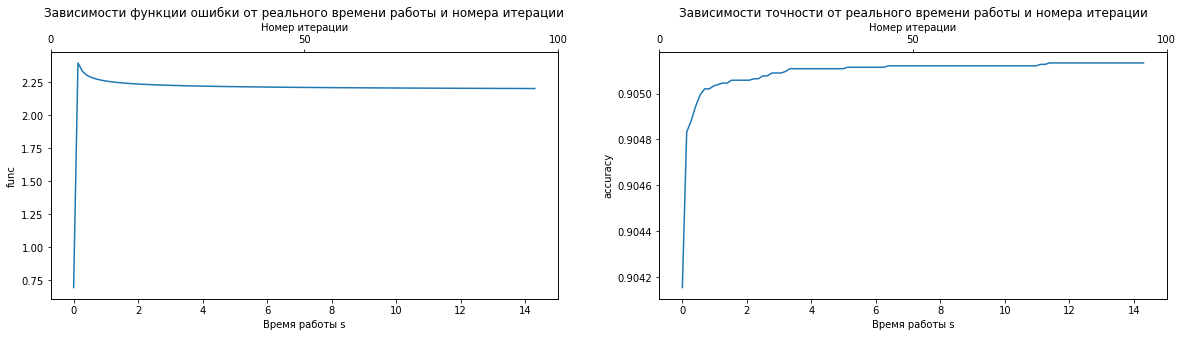

In [27]:
%%time
sgdc = SGDClassifier('binary_logistic', batch_size=5000, step_alpha=4.6, step_beta=1.5, 
                          tolerance=1e-4, max_iter=500, random_seed=153, l2_coef=0.0)
history = sgdc.fit(X_train, y_train, trace=True)
y_pred = sgdc.predict(X_test)
pred_proba = sgdc.predict_proba(X_test)
plots(history)

#### 1) Зависимость от параметров шага

In [28]:
df_history = pd.DataFrame(columns=['step_alpha', 'step_beta', 'accuracy', 'time', 'history'])

for step_alpha in np.arange(0.1, 5.1, 0.5):
    for step_beta in np.arange(0.0, 2.0, 0.5):
        sgdc = SGDClassifier('binary_logistic', batch_size=5000, step_alpha=step_alpha, step_beta=step_beta, 
                          tolerance=1e-4, max_iter=500, random_seed=153, l2_coef=0.0)
        start = time()
        history = sgdc.fit(X_train, y_train, trace=True)
        y_pred = sgdc.predict(X_test)
        pred_proba = sgdc.predict_proba(X_test)
        df_history = df_history.append({
            'step_alpha': round(step_alpha, 1),
            'step_beta': round(step_beta, 1),
            'accuracy': accuracy_score(y_test, y_pred),
            'time': time() - start,
            'history': history
        }, ignore_index=True)


Тепловая карта для точности и числа итераций (эпох) стохастического спуска:

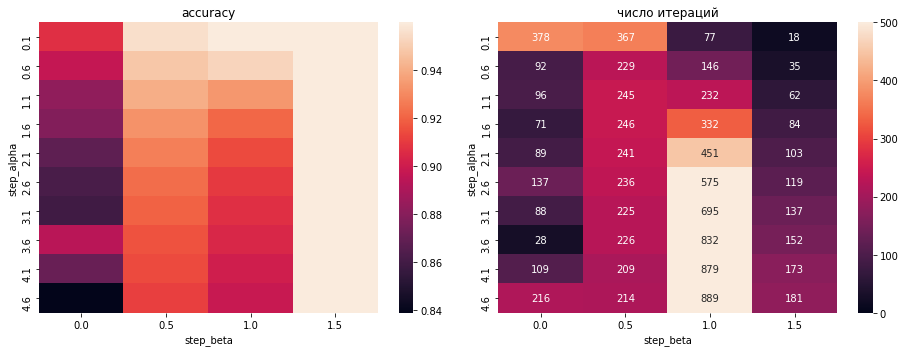

In [29]:
fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(121)
sns.heatmap(df_history.pivot('step_alpha', 'step_beta', 'accuracy'))
ax1.set(xlabel='step_beta', ylabel='step_alpha', title='accuracy')

ax2 = fig.add_subplot(122)

sns.heatmap((500/47 * df_history.pivot('step_alpha', 'step_beta', 'time')).astype(int), annot=True, fmt="d", vmin=0, vmax=500)
ax2.set(xlabel='step_beta', ylabel='step_alpha', title='число итераций')

plt.tight_layout()

#### 3) Зависимость от начального приближения

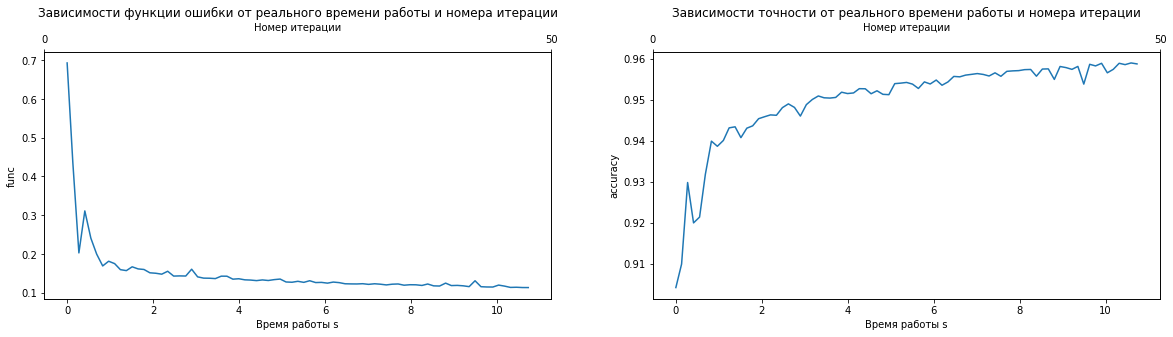

In [30]:
sgdc = SGDClassifier('binary_logistic', batch_size=5000, step_alpha=2.6, step_beta=0.0, 
                          tolerance=1e-4, max_iter=500, random_seed=153, l2_coef=0.0)
history = sgdc.fit(X_train, y_train, trace=True)
plots(history)

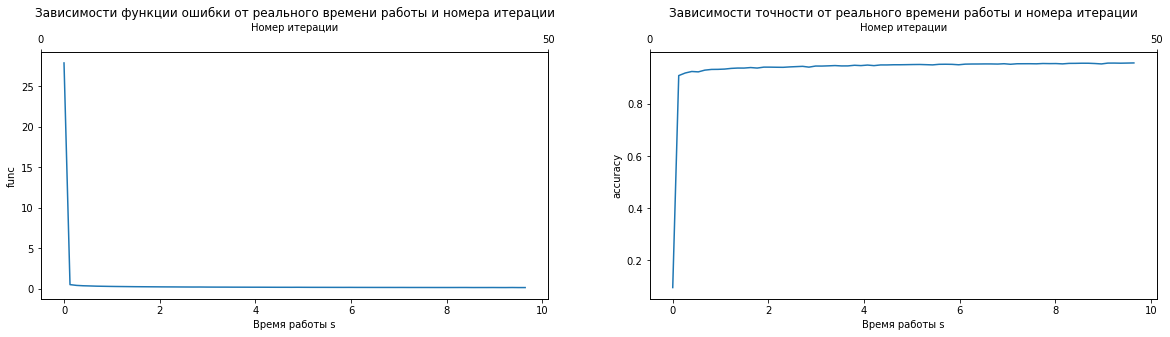

In [31]:
w_0 = (sgdc.get_weights() + 1) / 2
history = sgdc.fit(X_train, y_train, trace=True, w_0=w_0)
plots(history)

### 4. Лемматизация

In [32]:
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/youngcat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/youngcat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/youngcat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [33]:
lm = WordNetLemmatizer()

Пример работы:

In [34]:
print(lm.lemmatize('cats'))

cat


Теория с https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

In [35]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Семплируем выборку, чтобы не лемматизировать 160 тысяч строк. Оставим только 10%

In [36]:
df_train_sample = df_train.sample(frac = 0.1, random_state=42)
df_test_sample = df_test.sample(frac = 0.1, random_state=42)
df_test_labels_sample = df_test_labels.sample(frac = 0.1, random_state=42)
y_train = df_train_sample['toxic'].replace(0, -1)
y_test = df_test_labels_sample['toxic'].replace(0, -1)

Оценим размерность векторного пространства

In [37]:
X_train = standart(df_train_sample)
X_test = standart(df_test_sample)
X_train, X_test = sparsizer(1, X_train, X_test, 'count')
X_train

<15957x45903 sparse matrix of type '<class 'numpy.float64'>'
	with 693774 stored elements in COOrdinate format>

In [38]:
X_train = standart(df_train_sample)
X_test = standart(df_test_sample)
X_train, X_test = sparsizer(0.0001, X_train, X_test, 'count')
X_train

<15957x18821 sparse matrix of type '<class 'numpy.float64'>'
	with 666692 stored elements in COOrdinate format>

In [39]:
def lemmatizing(X):
    text = []
    for comment in X:
        text.append(" ".join([lm.lemmatize(word, get_wordnet_pos(word)) 
                                    for word in nltk.word_tokenize(comment)]))
    return text

In [40]:
%%time
X_train_lm = standart(df_train_sample)
X_test_lm = standart(df_test_sample)
X_train_lm = lemmatizing(X_train_lm)
X_test_lm = lemmatizing(X_test_lm)
X_train_lm, X_test_lm = sparsizer(1, X_train_lm, X_test_lm, 'count')
X_train_lm

CPU times: user 2min 27s, sys: 5.13 s, total: 2min 32s
Wall time: 2min 32s


<15957x39093 sparse matrix of type '<class 'numpy.float64'>'
	with 658222 stored elements in COOrdinate format>

In [41]:
%%time
X_train_lm = standart(df_train_sample)
X_test_lm = standart(df_test_sample)
X_train_lm = lemmatizing(X_train_lm)
X_test_lm = lemmatizing(X_test_lm)
X_train_lm, X_test_lm = sparsizer(0.0001, X_train_lm, X_test_lm, 'count')
X_train_lm

CPU times: user 2min 28s, sys: 4.77 s, total: 2min 33s
Wall time: 2min 33s


<15957x15167 sparse matrix of type '<class 'numpy.float64'>'
	with 634296 stored elements in COOrdinate format>

Запустим логистическую регрессию на лемматизированном датасете и визуализируем различия между подходами с лемматизацией и без

In [42]:
gdc = GDClassifier('binary_logistic', step_alpha=5.0, step_beta=0.1, tolerance=1e-5, max_iter=500, l2_coef=0)

accuracy for train: 0.955 accuracy for test: 0.905
CPU times: user 15 s, sys: 40.3 s, total: 55.4 s
Wall time: 3.57 s


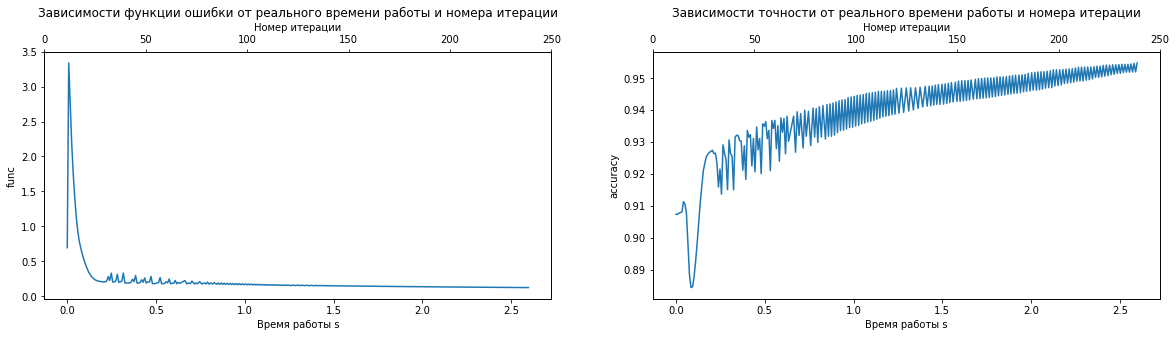

In [43]:
%%time
history = gdc.fit(X_train, y_train, w_0=None, trace=True)
y_pred = gdc.predict(X_test)
pred_proba = gdc.predict_proba(X_test)
print('accuracy for train: {:.3f} accuracy for test: {:.3f}'.format(history['accuracy'][-1],
                                                                    accuracy_score(y_test, y_pred)))
plots(history)

accuracy for train: 0.963 accuracy for test: 0.885
CPU times: user 24.5 s, sys: 1min 4s, total: 1min 29s
Wall time: 5.76 s


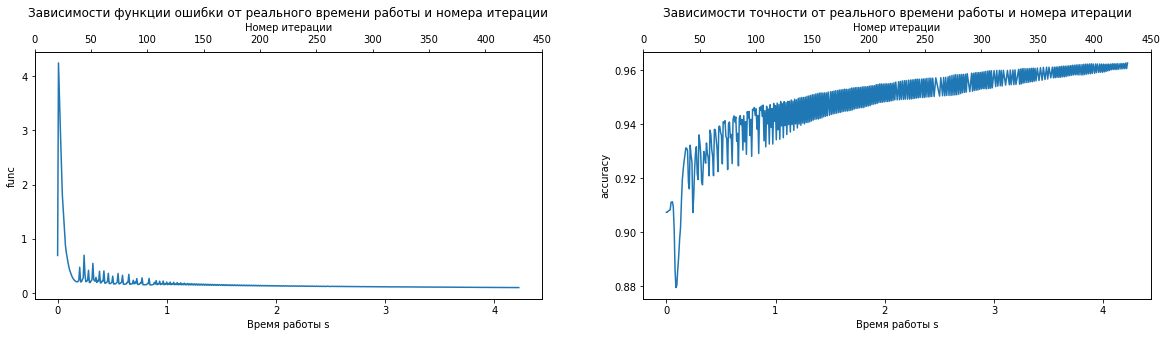

In [44]:
%%time
history = gdc.fit(X_train_lm, y_train, w_0=None, trace=True)
y_pred = gdc.predict(X_test_lm)
pred_proba = gdc.predict_proba(X_test_lm)
print('accuracy for train: {:.3f} accuracy for test: {:.3f}'.format(history['accuracy'][-1],
                                                                    accuracy_score(y_test, y_pred)))
plots(history)

### 5. TfidfVectorizer

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

Рассмотрим 4 варианта спуска: с лемматизацией и без, с помощью Count.Vectorizer и TfidfVectorizer

In [46]:
def enum_vectorizer(df_train_sample, df_test_sample, lem, vectorizer):
    X_train = standart(df_train_sample)
    X_test = standart(df_test_sample)
    
    if lem:
        X_train = lemmatizing(X_train)
        X_test = lemmatizing(X_test)
        
    X_train, X_test = sparsizer(0.0001, X_train, X_test, vectorizer)
    gdc = GDClassifier('binary_logistic', step_alpha=5.0, step_beta=0.1, tolerance=1e-5, max_iter=500, l2_coef=0)
    history = gdc.fit(X_train, y_train, w_0=None, trace=True)
    y_pred = gdc.predict(X_test)
    pred_proba = gdc.predict_proba(X_test)
    plots(history)
    return history['accuracy'][-1], accuracy_score(y_test, y_pred)

CPU times: user 6min 29s, sys: 4min 15s, total: 10min 44s
Wall time: 5min 30s


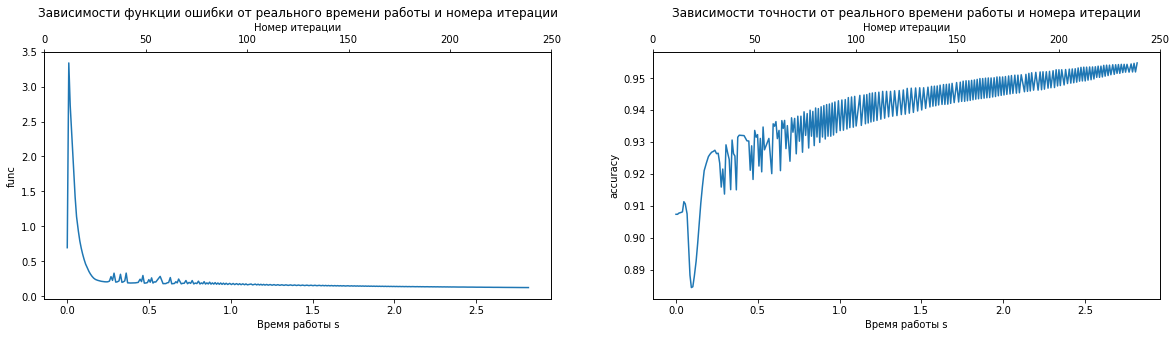

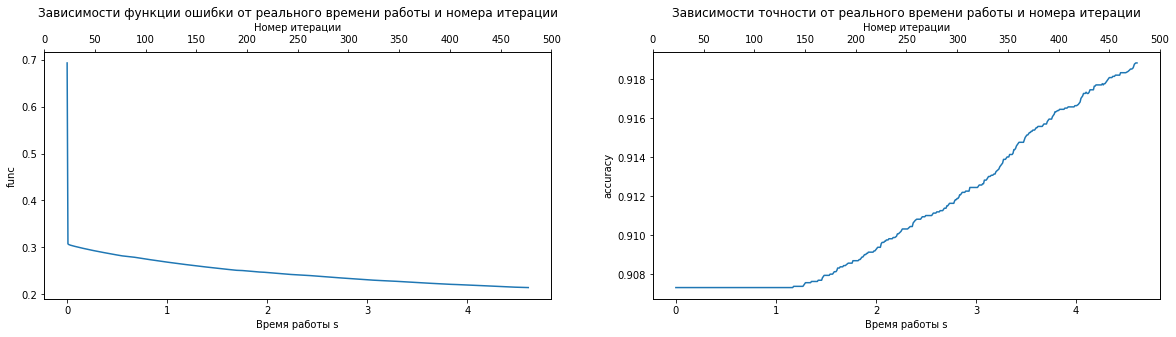

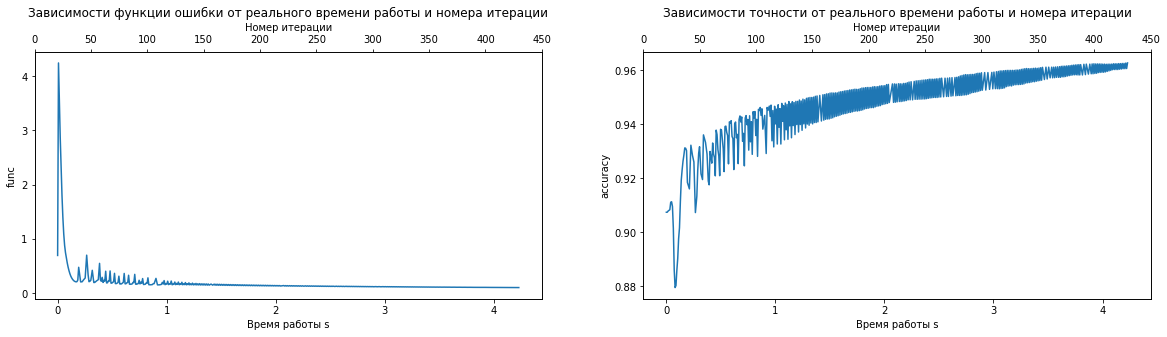

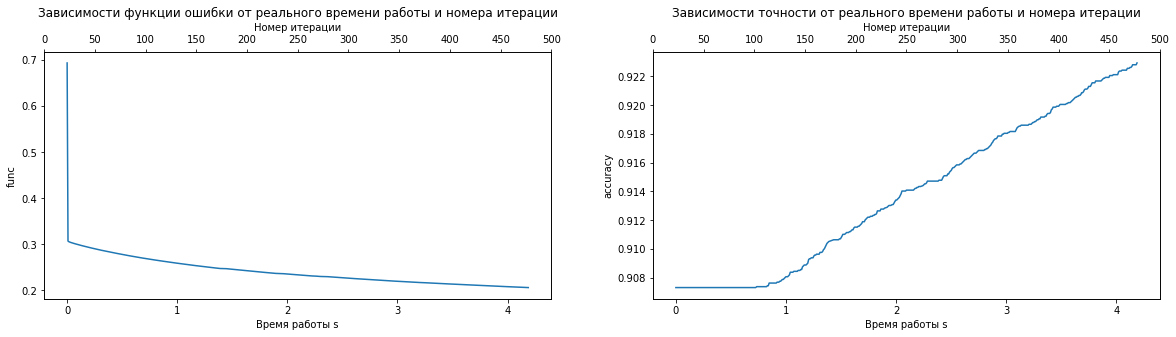

In [47]:
%%time
acc_map = pd.DataFrame(columns=['lem', 'vectorizer', 'train_accuracy', 'test_accuracy'])
for lem in (False, True):
    for vectorizer in ('count', 'tfid'):
        train_accuracy, test_accuracy = enum_vectorizer(df_train_sample, 
                                                        df_test_sample, lem=lem, vectorizer=vectorizer)
        acc_map = acc_map.append({'lem': lem, 'vectorizer': vectorizer, 
                          'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}, 
                         ignore_index=True)

Изобразим тепловую карту точности этих 4 методов

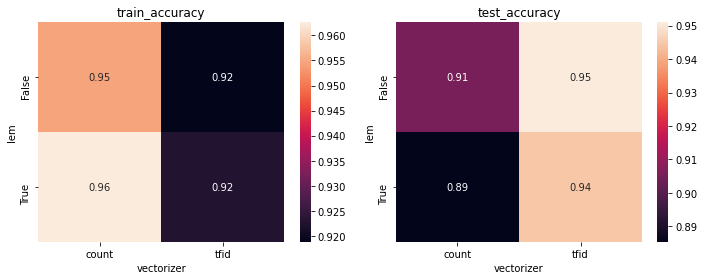

In [48]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
sns.heatmap(acc_map.pivot('lem', 'vectorizer', 'train_accuracy'), annot=True)
ax1.set(xlabel='vectorizer', ylabel='lem', title='train_accuracy')
ax1.set_xticklabels(['count', 'tfid'])
ax1.set_yticklabels([False, True])

ax2 = fig.add_subplot(122)
sns.heatmap(acc_map.pivot('lem', 'vectorizer', 'test_accuracy'), annot=True)
ax2.set(xlabel='vectorizer', ylabel='lem', title='test_accuracy')
ax2.set_xticklabels(['count', 'tfid'])
ax2.set_yticklabels([False, True])

plt.tight_layout()

Обучим алгоритм по лучшей стратегии

In [49]:
X_train = standart(df_train_sample)
X_test = standart(df_test_sample)
X_train, X_test = sparsizer(0.0001, X_train, X_test, vectorizer)
gdc = GDClassifier('binary_logistic', step_alpha=5.0, step_beta=0.1, tolerance=1e-5, max_iter=500, l2_coef=0)
gdc.fit(X_train, y_train, w_0=None)
y_pred = gdc.predict(X_test)
pred_proba = gdc.predict_proba(X_test)

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

Проанализируем матрицу ошибок на нем

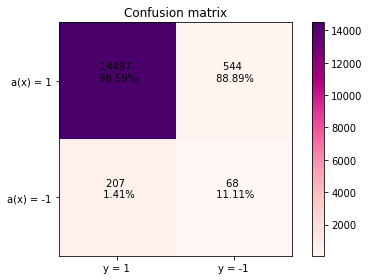

In [51]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
plt.title('Confusion matrix')
plt.colorbar()
plt.yticks([0, 1], ['a(x) = 1', 'a(x) = -1'])
plt.xticks([0, 1], ['y = 1', 'y = -1'])
   
max_ = cm.max() / 2.0
for i in (0, 1):
    for j in (0, 1):
        
        plt.text(i, j, '{} \n {:.2f}%'.format(cm[i, j], cm_norm[i, j]), horizontalalignment="center",
                color="black")

plt.tight_layout()
plt.show()

In [52]:
print('precision: {:.3f}, recall: {:.3f}'.format(precision_score(y_test, y_pred), 
                                                 recall_score(y_test, y_pred)))

precision: 0.247, recall: 0.111
